# Initial Setup

In [166]:
# For better sorting of column names in some exercises.
!pip install natsort

In [167]:
# Initial imports.
from typing import Tuple, List

import numpy as np
import pandas as pd
import sklearn.model_selection as skm
import sklearn.linear_model as skl

from natsort import natsorted
from functools import partial
from ISLP import load_data
from l0bnb import fit_path

from matplotlib.pyplot import subplots
from matplotlib import pyplot as plt
from statsmodels.api import OLS
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression

from ISLP.models import ModelSpec as MS
from ISLP.models import (
    Stepwise ,
    sklearn_selected ,
    sklearn_selection_path 
)

## Laboratory: Linear Models and Regularization Methods

### Subset Selection Methods

#### Forward Selection

In [168]:
Hitters = load_data("Hitters")

np.isnan(Hitters["Salary"]).sum()

59

In [169]:
Hitters: pd.DataFrame = Hitters.dropna()

# Show it.
Hitters

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.0,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.0,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.0,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.0,A


In [170]:
def nCp(sigma2, estimator, X, Y):
    """
    Negative Cp statistic.
    """
    
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    
    return -(RSS + 2 * p * sigma2) / n

In [171]:
design = MS(Hitters.columns.drop("Salary")).fit(Hitters)

Y: np.array = np.array(Hitters["Salary"])
X: pd.DataFrame = design.transform(Hitters)

sigma2: float = OLS(Y,X).fit().scale

sigma2

99591.3561796822

In [172]:
neg_Cp = partial(nCp, sigma2)
neg_Cp?

Signature:      neg_Cp(estimator, X, Y)
Call signature: neg_Cp(*args, **kwargs)
Type:           partial
String form:    functools.partial(<function nCp at 0x7f33788dfe20>, 99591.3561796822)
File:           /usr/lib/python3.10/functools.py
Docstring:     
partial(func, *args, **keywords) - new function with partial application
of the given arguments and keywords.

In [173]:
strategy = Stepwise.first_peak(
    model_spec=design,
    direction="forward",
    max_terms=len(design.terms)
)

In [174]:
%%time

hitters_MSE = sklearn_selected(OLS, strategy)
hitters_MSE.fit(Hitters, Y)
hitters_MSE.selected_state_

CPU times: user 1.71 s, sys: 14 µs, total: 1.71 s
Wall time: 1.71 s


('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

In [175]:
%%time

hitters_Cp = sklearn_selected(OLS, strategy, scoring=neg_Cp)
hitters_Cp.fit(Hitters, Y)
hitters_Cp.selected_state_

CPU times: user 1.08 s, sys: 0 ns, total: 1.08 s
Wall time: 1.07 s


('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

#### Choosing Among Models Using the Validation Set Approach and Cross-Validation

In [176]:
strategy = Stepwise.fixed_steps(
    design,
    len(design.terms),
    direction='forward'
)

full_path = sklearn_selection_path(OLS, strategy)
full_path

sklearn_selection_path(model_type=<class 'statsmodels.regression.linear_model.OLS'>,
                       strategy=Strategy(initial_state=(), candidate_states=<bound method Stepwise.candidate_states of <ISLP.models.strategy.Stepwise object at 0x7f325c1c21d0>>, build_submodel=<bound method ModelSpec.build_submodel of ModelSpec(terms=Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division',
       'PutOuts', 'Assists', 'Errors', 'NewLeague'],
      dtype='object'))>, check_finished=functools.partial(<function fixed_steps at 0x7f3261fc8b80>, 19), postprocess=functools.partial(<function _postprocess_fixed_steps at 0x7f3261fc8ca0>, 19)))

In [177]:
%%time

full_path.fit(Hitters, Y)
Yhat_in: np.ndarray = full_path.predict(Hitters)
Yhat_in.shape

CPU times: user 1.04 s, sys: 10 ms, total: 1.05 s
Wall time: 1.05 s


(263, 20)

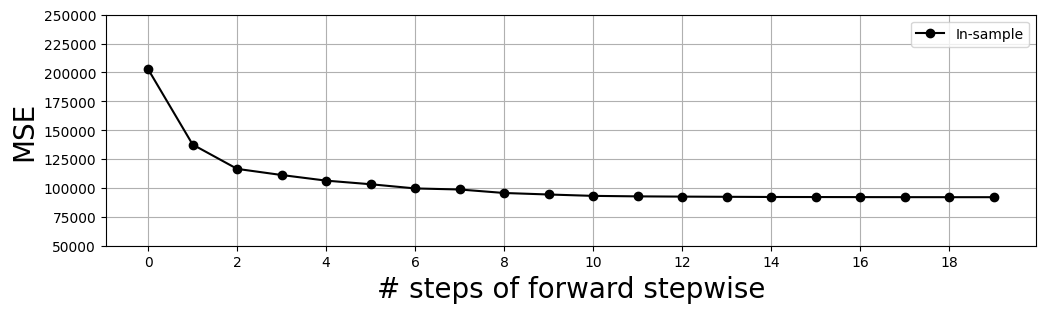

In [178]:
mse_fig, ax = subplots(figsize=(12, 3))

insample_mse: np.ndarray = ((Yhat_in - Y[:, None]) ** 2).mean(0)
n_steps: int = insample_mse.shape[0]

ax.plot(
    np.arange(n_steps),
    insample_mse,
    marker="o",
    color="k",  # color black
    label="In-sample"
)
ax.set_ylabel("MSE", fontsize=20)
ax.set_xlabel("# steps of forward stepwise", fontsize=20)
ax.set_xticks(np.arange(n_steps))
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.grid()
ax.set_ylim([50000, 250000]);

In [179]:
%%time

K: int = 5
kfold = skm.KFold(K, random_state=0, shuffle=True)
Yhat_cv: np.ndarray = skm.cross_val_predict (full_path, Hitters, Y, cv=kfold)

Yhat_cv.shape

CPU times: user 5.1 s, sys: 0 ns, total: 5.1 s
Wall time: 5.09 s


(263, 20)

In [180]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y):

    errors = (Yhat_cv[test_idx] - Y[test_idx, None])**2
    
    # Column means.
    cv_mse.append(errors.mean(0))  

cv_mse = np.array(cv_mse).T

cv_mse.shape

(20, 5)

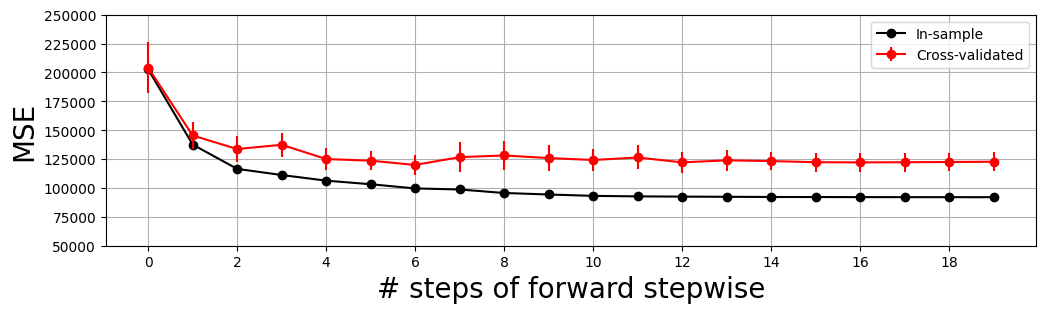

In [181]:
ax.errorbar(
    np.arange(n_steps),
    cv_mse.mean(axis=1),
    cv_mse.std(axis=1) / np.sqrt(K),
    label="Cross-validated",
    color="red",
    marker="o"
)

ax.set_ylim([50000, 250000])
ax.legend()
mse_fig

In [182]:
validation = skm.ShuffleSplit(
    n_splits=1, test_size=0.2, random_state=0
)

for train_idx, test_idx in validation.split(Y):
    
    full_path.fit(Hitters.iloc[train_idx], Y[train_idx])
    Yhat_val = full_path.predict(Hitters.iloc[test_idx])
    errors = (Yhat_val - Y[test_idx, None])**2
    
    validation_mse = errors.mean(0)

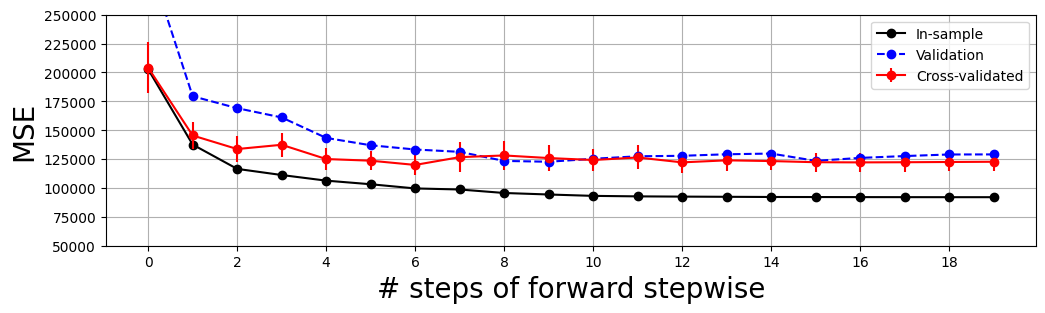

In [183]:
ax.plot(
    np.arange(n_steps), 
    validation_mse, 
    marker="o",
    color="blue",
    linestyle="--", # color blue, broken line
    label="Validation")

ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim([50000, 250000])
ax.legend()
mse_fig

#### Best Subset Selection

In [184]:
D = design.fit_transform(Hitters)
D = D.drop("intercept", axis=1)
X = np.asarray(D)

X.shape

(263, 19)

In [185]:
%%time

path = fit_path(X, Y, max_nonzeros=X.shape[1])
path[3]

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2


Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  4
Iteration: 8. Number of non-zeros:  9
Iteration: 9. Number of non-zeros:  9
Iteration: 10. Number of non-zeros:  9
Iteration: 11. Number of non-zeros:  9
Iteration: 12. Number of non-zeros:  9
Iteration: 13. Number of non-zeros:  9
Iteration: 14. Number of non-zeros:  9
Iteration: 15. Number of non-zeros:  9
Iteration: 16. Number of non-zeros:  9
Iteration: 17. Number of non-zeros:  9
Iteration: 18. Number of non-zeros:  17
Iteration: 19. Number of non-zeros:  19
CPU times: user 3min 8s, sys: 23.5 ms, total: 3min 8s
Wall time: 3.95 s


{'B': array([0.        , 3.25484367, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.67775265, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 'B0': -38.98216739555505,
 'lambda_0': 0.011416248027450187,
 'M': 0.5829861733382012,
 'Time_exceeded': False}

### Ridge Regression and the Lasso

## Exercises

### Ancillar Functions

In [186]:
def adjust_linear_model(
        dfX: pd.DataFrame, 
        dfY: pd.DataFrame
    ) -> Tuple[OLS, float, float, float, float]:
    """
    Adjust a linear model with all predictors.
    """
    
    linear_model = OLS(endog=dfY, exog=dfX).fit()

    return linear_model, linear_model.ssr, linear_model.rsquared, linear_model.bic, linear_model.aic


def forward_stepwise_selection(
        dfX: pd.DataFrame, 
        dfY: pd.DataFrame
    ) -> Tuple[List[int], List[float], List[float], List[float], List[float], List[float], List[OLS]]:
    """
    Forward stepwise selection.
    """
    
    print(">>> Starting forward stepwise selection...")

    # Initially all predictor are available.
    all_features: List[str] = dfX.columns.to_list()
    available_features: List[str] = dfX.columns.to_list()
    used_features: List[str] = []

    # Initialize some metrics to be used as a function of the number of used features.
    n_features: List[int] = []
    rss_list: List[float] = []
    r2_list: List[float] = []
    bic_list: List[float] = []
    aic_list: List[float] = []
    cp_list: List[float] = []
    best_models: List[OLS] = []

    # Initialize best Cp as very low.
    best_cp: float = -np.inf

    while len(used_features) < len(all_features):

        # Loop over all predictors.
        for feature in available_features:
            
            # If feature not already used.
            if feature not in used_features:

                # Candidates to test.
                tested_features: List[str] = used_features + [feature]

                print(f">>> Testing features: {tested_features}")

                # Fit model with current feature.
                model, rss, r2, bic, aic = adjust_linear_model(dfX[tested_features], dfY)

                # Calculate cp.
                cp: float = neg_Cp(model, dfX[tested_features], dfY["Y"])

                print(f"\t* metrics: CP={cp:.2f} (bestCP={best_cp:.2f}), RSS={rss:.2f}, R2={r2:.2f}, BIC={bic:.2f}, AIC={aic:.2f}")

                # Verify if the model is better according to Cp.
                if cp > best_cp:

                    # Update best metrics.
                    best_cp: float = cp
                    best_rss: float = rss
                    best_r2: float = r2
                    best_bic: float = bic
                    best_aic: float = aic

                    # Update best feature.
                    best_feature: str = feature

                    # Best model.
                    best_model: OLS = model

        # Update lists.
        used_features.append(best_feature)
        n_features.append(len(used_features))
        rss_list.append(best_rss)
        r2_list.append(best_r2)
        bic_list.append(best_bic)
        aic_list.append(best_aic)
        cp_list.append(best_cp)
        available_features.remove(best_feature)
        best_models.append(best_model)

        print(f"\t* Diagnostic: used features: {used_features}, Cp: {best_cp:.2f}, RSS: {best_rss:.2f}, R2: {best_r2:.2f}")

        # Reset best Cp for next round.
        best_cp = -np.inf

    print("\n>>> Done!")    

    return n_features, rss_list, r2_list, bic_list, aic_list, cp_list, best_models


def backward_stepwise_selection(
        dfX: pd.DataFrame, 
        dfY: pd.DataFrame
    ) -> Tuple[List[int], List[float], List[float], List[float], List[float], List[float], List[OLS]]:
    """
    Backward stepwise selection.
    """
    
    # Skeleton for backward stepwise selection.
    all_features: List[str] = dfX.columns.to_list()
    tested_features: List[str] = all_features.copy()
    candidates: List[str] = all_features.copy()

    # Initialize some metrics to be used as a function of the number of used features.
    n_features: List[int] = []
    rss_list: List[float] = []
    r2_list: List[float] = []
    bic_list: List[float] = []
    aic_list: List[float] = []
    cp_list: List[float] = []
    best_models: List[OLS] = []

    # Adjust linear model with all predictors.
    model, rss, r2, bic, aic = adjust_linear_model(dfX, dfY)

    # Calculate cp.
    cp: float = neg_Cp(model, dfX[tested_features], dfY["Y"])    

    n_features.append(len(all_features))
    rss_list.append(rss)
    r2_list.append(r2)
    bic_list.append(bic)
    aic_list.append(aic)
    cp_list.append(cp)
    best_models.append(model)

    # Initialize best Cp as very low.
    best_cp: float = -np.inf

    while len(candidates) > 1:

        print(f">>> Candidates to remove: {candidates}")

        # Loop over candidates to be removed.
        for candidate in all_features:

            # Is this a valid candidate?
            if candidate in candidates:

                # Features to be tested.
                tested_features = natsorted(list(set(candidates) - set([candidate])))

                print(f"\t* Exclude {candidate}:")

                # Adjust model and calculate metrics.
                model, rss, r2, bic, aic = adjust_linear_model(dfX[tested_features], dfY)

                # Calculate cp.
                cp: float = neg_Cp(model, dfX[tested_features], dfY["Y"])

                print(f"\t\t* metrics: CP={cp:.2f} (bestCP={best_cp:.2f}), RSS={rss:.2f}, R2={r2:.2f}, BIC={bic:.2f}, AIC={aic:.2f}")

                # Verify if the model is better according to Cp.
                if cp > best_cp:

                    # Update best metrics.
                    best_cp: float = cp
                    best_rss: float = rss
                    best_r2: float = r2
                    best_bic: float = bic
                    best_aic: float = aic

                    # Update best feature.
                    removed_feature: str = candidate
                    used_features: List[str] = tested_features

                    # Best model.
                    best_model: OLS = model
                
        # Select feature to be removed.
        print(f"\t* Removed feature: {removed_feature}")
        candidates.remove(removed_feature)    

        # Update lists.
        n_features.append(len(used_features))
        rss_list.append(best_rss)
        r2_list.append(best_r2)
        bic_list.append(best_bic)
        aic_list.append(best_aic)
        cp_list.append(best_cp)
        best_models.append(best_model)

        print(f"\t* Diagnostic:")
        print(f"\t\t* used features: {used_features}")
        print(f"\t\t* Cp: {best_cp:.2f}, RSS: {best_rss:.2f}, R2: {best_r2:.2f}")

        # Reset best Cp for next round.
        best_cp = -np.inf    

    return n_features, rss_list, r2_list, bic_list, aic_list, cp_list, best_models

### Conceptual

### Applied

#### 8

In [187]:
# a)

# Random predictors and noise.
X: np.ndarray = np.random.normal(loc=0.0, scale=1.0, size=(100, 1))
eps: np.ndarray = np.random.normal(loc=0.0, scale=1.0, size=(100, 1))

In [188]:
# b)

# Real parameters that generate data.
B0: float = 5.0
B1: float = -10.0
B2: float = 3.0
B3: float = 14.0

# Response.
Y: np.ndarray = B0 + B1*X + B2*(X**2) + B3*(X**3) + eps

# To dataframes.
dfY: pd.DataFrame = pd.DataFrame(Y, columns=["Y"])
dfY

,Y
0,35.072556
1,7.285632
2,2.411914
3,1.642917
4,5.646700
...,...
95,12.887938
96,7.886824
97,9.071829
98,25.936110


In [189]:
# c)

# As dataframe with intercept.
Features: np.ndarray = np.hstack([X**i for i in range(0, 11)])
dfX = pd.DataFrame(Features, columns=[f"X{i}" for i in range(0, 11)])
dfX

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,1.0,1.393191,1.940981,2.704156,3.767406,5.248715,7.312461,1.018765e+01,1.419335e+01,1.977404e+01,2.754901e+01
1,1.0,-0.179881,0.032357,-0.005820,0.001047,-0.000188,0.000034,-6.093890e-06,1.096174e-06,-1.971808e-07,3.546904e-08
2,1.0,-1.020191,1.040790,-1.061805,1.083244,-1.105116,1.127430,-1.150194e+00,1.173418e+00,-1.197111e+00,1.221282e+00
3,1.0,-1.040851,1.083371,-1.127627,1.173692,-1.221638,1.271543,-1.323487e+00,1.377553e+00,-1.433827e+00,1.492400e+00
4,1.0,-0.109117,0.011906,-0.001299,0.000142,-0.000015,0.000002,-1.841783e-07,2.009693e-08,-2.192911e-09,2.392832e-10
...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,1.044207,1.090368,1.138569,1.188902,1.241459,1.296340,1.353647e+00,1.413487e+00,1.475972e+00,1.541220e+00
96,1.0,-0.631785,0.399152,-0.252178,0.159322,-0.100657,0.063594,-4.017751e-02,2.538353e-02,-1.603692e-02,1.013188e-02
97,1.0,-0.775851,0.601945,-0.467019,0.362337,-0.281120,0.218107,-1.692185e-01,1.312884e-01,-1.018602e-01,7.902832e-02
98,1.0,1.294970,1.676948,2.171597,2.812153,3.641654,4.715833,6.106863e+00,7.908205e+00,1.024089e+01,1.326165e+01


In [190]:
# Adjust a linear model with all predictors.
linear_model = OLS(endog=dfY, exog=dfX).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.523e+04
Date:                Thu, 02 Oct 2025   Prob (F-statistic):          2.61e-139
Time:                        15:19:11   Log-Likelihood:                -132.99
No. Observations:                 100   AIC:                             288.0
Df Residuals:                      89   BIC:                             316.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X0             5.0335      0.199     25.324      0.000       4.639       5.428
X1           -11.1070      0.792    -14.019      0.000     -12.681      -9.533
X2             4.1278      1.513      2.728      0.008       1.121       7.134
X3            17.2729      3.022      5.716      0.000      11.269      23.277
X4            -3.3440      2.620     -1.276      0.205      -8.550       1.862
X5            -3.3552      3.624     -0.926      0.357     -10.556       3.846
X6             2.5890      1.744      1.485      0.141      -0.876       6.053
X7             1.3697      1.647      0.832      0.408      -1.903       4.642
X8            -0.7983      0.577     -1.384      0.170      -1.945       0.348
X9            -0.1824      0.250     -0.730      0.467      -0.679       0.314
X10            0.0894      0.085      1.053      0.295      -0.079       0.258
==============================================================================
Omnibus:                        4.616   Durbin-Watson:                   2.309
Prob(Omnibus):                  0.099   Jarque-Bera (JB):                4.006
Skew:                           0.469   Prob(JB):                        0.135
Kurtosis:                       3.288   Cond. No.                     5.55e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.55e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [191]:
# Model selection criterion scorer.
sigma2 = linear_model.scale
neg_Cp = partial(nCp , sigma2)

In [192]:
# Run forward stepwise selection.
n_features, rss_list, r2_list, bic_list, aic_list, cp_list, best_models = forward_stepwise_selection(dfX, dfY)

>>> Starting forward stepwise selection...
>>> Testing features: ['X0']
	* metrics: CP=-1432.67 (bestCP=-inf), RSS=143264.94, R2=0.00, BIC=1015.12, AIC=1012.52
>>> Testing features: ['X1']
	* metrics: CP=-829.46 (bestCP=-1432.67), RSS=82943.72, R2=0.48, BIC=960.47, AIC=957.86
>>> Testing features: ['X2']
	* metrics: CP=-835.17 (bestCP=-829.46), RSS=83515.08, R2=0.47, BIC=961.15, AIC=958.55
>>> Testing features: ['X3']
	* metrics: CP=-121.21 (bestCP=-829.46), RSS=12118.90, R2=0.92, BIC=768.13, AIC=765.52
>>> Testing features: ['X4']
	* metrics: CP=-423.74 (bestCP=-121.21), RSS=42372.52, R2=0.73, BIC=893.30, AIC=890.70
>>> Testing features: ['X5']
	* metrics: CP=-67.26 (bestCP=-121.21), RSS=6723.63, R2=0.96, BIC=709.21, AIC=706.61
>>> Testing features: ['X6']
	* metrics: CP=-292.27 (bestCP=-67.26), RSS=29224.91, R2=0.82, BIC=856.15, AIC=853.55
>>> Testing features: ['X7']
	* metrics: CP=-135.83 (bestCP=-67.26), RSS=13581.10, R2=0.91, BIC=779.52, AIC=776.91
>>> Testing features: ['X8']
	*

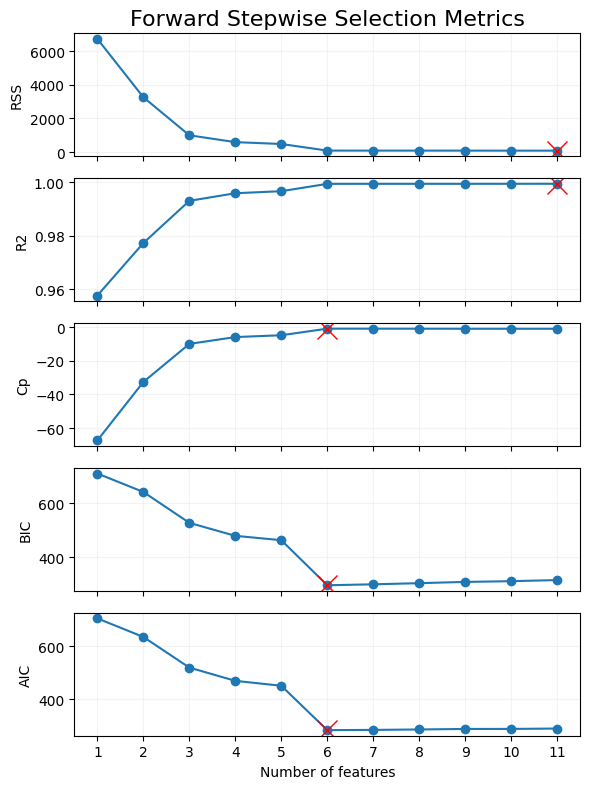

In [193]:
# Make figures.
fig, axs = subplots(5, 1, figsize=(6, 8), sharex=True)

# Plot metrics.
axs[0].plot(n_features, rss_list, marker="o")
axs[0].set_ylabel("RSS")
axs[1].plot(n_features, r2_list, marker="o")
axs[1].set_ylabel("R2")
axs[2].plot(n_features, cp_list, marker="o")
axs[2].set_ylabel("Cp")
axs[3].plot(n_features, bic_list, marker="o")
axs[3].set_ylabel("BIC")
axs[4].plot(n_features, aic_list, marker="o")
axs[4].set_ylabel("AIC")
axs[4].set_xlabel("Number of features")

# Plot minimum RSS as a red cross.
min_rss_idx = np.argmin(rss_list)
axs[0].plot(n_features[min_rss_idx], rss_list[min_rss_idx], marker="x", color="red", markersize=15)

# Plot maximum R2 as a red cross.
max_r2_idx = np.argmax(r2_list)
axs[1].plot(n_features[max_r2_idx], r2_list[max_r2_idx], marker="x", color="red", markersize=15)

# Plot maximum cp as a red cross.
max_cp_idx = np.argmax(cp_list)
axs[2].plot(n_features[max_cp_idx], cp_list[max_cp_idx], marker="x", color="red", markersize=15)

# Plot minimum BIC as a red cross.
min_bic_idx = np.argmin(bic_list)
axs[3].plot(n_features[min_bic_idx], bic_list[min_bic_idx], marker="x", color="red", markersize=15)

# Plot minimum AIC as a red cross.
min_aic_idx = np.argmin(aic_list)
axs[4].plot(n_features[min_aic_idx], aic_list[min_aic_idx], marker="x", color="red", markersize=15)

# X labels.
axs[4].set_xticks(n_features)

# Set grid for all axes.
for ax in axs:
    ax.grid(alpha=0.15)

# Title.
axs[0].set_title("Forward Stepwise Selection Metrics", fontsize=16)

plt.tight_layout()

In [194]:
# Expected coefficients.
df_compare_forward: pd.DataFrame = pd.DataFrame({
    "true": [B0, B1, B2, B3] + [0.0]*7
}, index=[f"X{i}" for i in range(0, 11)])

# Adjusted coefficients of the best model according to Cp, BIC, AIC, and R2.
df_cp: pd.DataFrame = best_models[max_cp_idx].params.to_frame(name="forward_cp")
df_bic: pd.DataFrame = best_models[min_bic_idx].params.to_frame(name="forward_bic")
df_aic: pd.DataFrame = best_models[min_aic_idx].params.to_frame(name="forward_aic")
df_r2: pd.DataFrame = best_models[max_r2_idx].params.to_frame(name="forward_r2")

# Join all dataframes.
df_compare_forward = df_compare_forward.join(df_cp, how="outer")
df_compare_forward = df_compare_forward.join(df_bic, how="outer")
df_compare_forward = df_compare_forward.join(df_aic, how="outer")  
df_compare_forward = df_compare_forward.join(df_r2, how="outer")

# Reduce float precision.
df_compare_forward = df_compare_forward.round(3)

# Better sorting of the index.
df_compare_forward = df_compare_forward.reindex(natsorted(df_compare_forward.index))

df_compare_forward

,true,forward_cp,forward_bic,forward_aic,forward_r2
X0,5.0,5.054,5.054,5.054,5.034
X1,-10.0,-10.322,-10.322,-10.322,-11.107
X2,3.0,2.849,2.849,2.849,4.128
X3,14.0,14.087,14.087,14.087,17.273
X4,0.0,NaN,NaN,NaN,-3.344
X5,0.0,0.110,0.110,0.110,-3.355
X6,0.0,NaN,NaN,NaN,2.589
X7,0.0,-0.018,-0.018,-0.018,1.370
X8,0.0,NaN,NaN,NaN,-0.798
X9,0.0,NaN,NaN,NaN,-0.182


In [ ]:
# c)

# Run backward stepwise selection.
n_features, rss_list, r2_list, bic_list, aic_list, cp_list, best_models = backward_stepwise_selection(dfX, dfY)

>>> Candidates to remove: ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10']
	* Exclude X0:
		* metrics: CP=-7.06 (bestCP=-inf), RSS=686.70, R2=1.00, BIC=522.51, AIC=496.46
	* Exclude X1:
		* metrics: CP=-2.87 (bestCP=-7.06), RSS=268.49, R2=1.00, BIC=428.60, AIC=402.55
	* Exclude X2:
		* metrics: CP=-1.09 (bestCP=-2.87), RSS=90.68, R2=1.00, BIC=320.06, AIC=294.01
	* Exclude X3:
		* metrics: CP=-1.33 (bestCP=-1.09), RSS=114.41, R2=1.00, BIC=343.30, AIC=317.25
	* Exclude X4:
		* metrics: CP=-1.04 (bestCP=-1.09), RSS=85.22, R2=1.00, BIC=313.84, AIC=287.79
	* Exclude X5:
		* metrics: CP=-1.03 (bestCP=-1.04), RSS=84.49, R2=1.00, BIC=312.99, AIC=286.94
	* Exclude X6:
		* metrics: CP=-1.05 (bestCP=-1.03), RSS=85.76, R2=1.00, BIC=314.48, AIC=288.43
	* Exclude X7:
		* metrics: CP=-1.03 (bestCP=-1.03), RSS=84.34, R2=1.00, BIC=312.80, AIC=286.75
	* Exclude X8:
		* metrics: CP=-1.04 (bestCP=-1.03), RSS=85.49, R2=1.00, BIC=314.16, AIC=288.11
	* Exclude X9:
		* metrics: CP=-1.03 (be

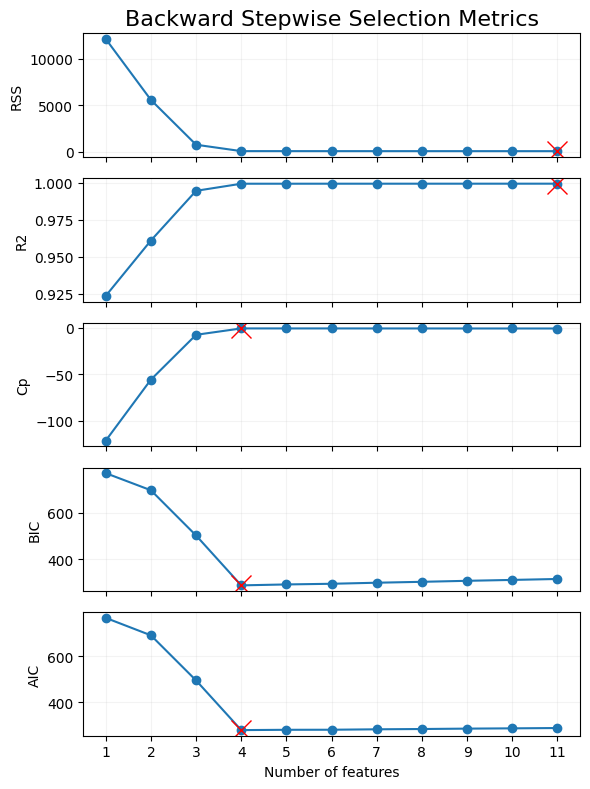

In [196]:
# Make figures.
fig, axs = subplots(5, 1, figsize=(6, 8), sharex=True)

# Plot metrics.
axs[0].plot(n_features, rss_list, marker="o")
axs[0].set_ylabel("RSS")
axs[1].plot(n_features, r2_list, marker="o")
axs[1].set_ylabel("R2")
axs[2].plot(n_features, cp_list, marker="o")
axs[2].set_ylabel("Cp")
axs[3].plot(n_features, bic_list, marker="o")
axs[3].set_ylabel("BIC")
axs[4].plot(n_features, aic_list, marker="o")
axs[4].set_ylabel("AIC")
axs[4].set_xlabel("Number of features")

# Plot minimum RSS as a red cross.
min_rss_idx = np.argmin(rss_list)
axs[0].plot(n_features[min_rss_idx], rss_list[min_rss_idx], marker="x", color="red", markersize=15)

# Plot maximum R2 as a red cross.
max_r2_idx = np.argmax(r2_list)
axs[1].plot(n_features[max_r2_idx], r2_list[max_r2_idx], marker="x", color="red", markersize=15)

# Plot maximum cp as a red cross.
max_cp_idx = np.argmax(cp_list)
axs[2].plot(n_features[max_cp_idx], cp_list[max_cp_idx], marker="x", color="red", markersize=15)

# Plot minimum BIC as a red cross.
min_bic_idx = np.argmin(bic_list)
axs[3].plot(n_features[min_bic_idx], bic_list[min_bic_idx], marker="x", color="red", markersize=15)

# Plot minimum AIC as a red cross.
min_aic_idx = np.argmin(aic_list)
axs[4].plot(n_features[min_aic_idx], aic_list[min_aic_idx], marker="x", color="red", markersize=15)

# X labels.
axs[4].set_xticks(n_features)

# Set grid for all axes.
for ax in axs:
    ax.grid(alpha=0.15)

# Title.
axs[0].set_title("Backward Stepwise Selection Metrics", fontsize=16)

plt.tight_layout()

In [197]:
# Initialize.
df_compare_backward: pd.DataFrame = pd.DataFrame({
    "true": [B0, B1, B2, B3] + [0.0]*7
}, index=[f"X{i}" for i in range(0, 11)])

# Adjusted coefficients of the best model according to Cp, BIC, AIC, and R2.
df_cp: pd.DataFrame = best_models[max_cp_idx].params.to_frame(name="backward_cp")
df_bic: pd.DataFrame = best_models[min_bic_idx].params.to_frame(name="backward_bic")
df_aic: pd.DataFrame = best_models[min_aic_idx].params.to_frame(name="backward_aic")
df_r2: pd.DataFrame = best_models[max_r2_idx].params.to_frame(name="backward_r2")

# Join all dataframes.
df_compare_backward = df_compare_backward.join(df_cp, how="outer")
df_compare_backward = df_compare_backward.join(df_bic, how="outer")
df_compare_backward = df_compare_backward.join(df_aic, how="outer")  
df_compare_backward = df_compare_backward.join(df_r2, how="outer")

# Reduce float precision.
df_compare_backward = df_compare_backward.round(3)

# Better sorting of the index.
df_compare_backward = df_compare_backward.reindex(natsorted(df_compare_backward.index))

# Show it.
df_compare_backward

,true,backward_cp,backward_bic,backward_aic,backward_r2
X0,5.0,5.081,5.081,5.081,5.034
X1,-10.0,-10.266,-10.266,-10.266,-11.107
X2,3.0,2.789,2.789,2.789,4.128
X3,14.0,14.176,14.176,14.176,17.273
X4,0.0,NaN,NaN,NaN,-3.344
X5,0.0,NaN,NaN,NaN,-3.355
X6,0.0,NaN,NaN,NaN,2.589
X7,0.0,NaN,NaN,NaN,1.370
X8,0.0,NaN,NaN,NaN,-0.798
X9,0.0,NaN,NaN,NaN,-0.182


In [198]:
# Join results dataframes.
df_results: pd.DataFrame = pd.concat([
        df_compare_forward, 
        df_compare_backward.drop(columns=["true"])
    ], 
    axis=1
).T

# Show it.
df_results

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
true,5.000,-10.000,3.000,14.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
forward_cp,5.054,-10.322,2.849,14.087,NaN,0.110,NaN,-0.018,NaN,NaN,NaN
forward_bic,5.054,-10.322,2.849,14.087,NaN,0.110,NaN,-0.018,NaN,NaN,NaN
forward_aic,5.054,-10.322,2.849,14.087,NaN,0.110,NaN,-0.018,NaN,NaN,NaN
forward_r2,5.034,-11.107,4.128,17.273,-3.344,-3.355,2.589,1.370,-0.798,-0.182,0.089
backward_cp,5.081,-10.266,2.789,14.176,NaN,NaN,NaN,NaN,NaN,NaN,NaN
backward_bic,5.081,-10.266,2.789,14.176,NaN,NaN,NaN,NaN,NaN,NaN,NaN
backward_aic,5.081,-10.266,2.789,14.176,NaN,NaN,NaN,NaN,NaN,NaN,NaN
backward_r2,5.034,-11.107,4.128,17.273,-3.344,-3.355,2.589,1.370,-0.798,-0.182,0.089
